In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats

# Import the 'resample' function from sklearn.utils for resampling (upsampling or downsampling) data
from sklearn.utils import resample


# Preprocessing techniques like transformation and encoding
from sklearn.preprocessing import PowerTransformer, OneHotEncoder

# For applying transformations to columns
from sklearn.compose import ColumnTransformer

# Pipeline construction for simplifying workflow
from sklearn.pipeline import Pipeline

# Model selection and evaluation
from sklearn.model_selection import train_test_split

# Various machine learning classifiers for classification tasks
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Additional classifiers from lightgbm, xgboost, and catboost libraries
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier

# Evaluation metrics for classification model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-accident-prediction/dataset_traffic_accident_prediction1.csv
/kaggle/input/data-cleaning-challenge-handling-missing-values/__results__.html
/kaggle/input/data-cleaning-challenge-handling-missing-values/__output__.json
/kaggle/input/data-cleaning-challenge-handling-missing-values/custom.css
/kaggle/input/digitalizations-impact-on-economic-growth/Data base International Panel Data Analysis of the Effect of Digitalization on Economic Growth.xlsx
/kaggle/input/tracking-global/electric-car-sales-share NEW.csv
/kaggle/input/social-media-advertising-effectiveness/modified_data_9.csv
/kaggle/input/amazon-reviews-dataset/Reviews.csv


In [2]:
# read in all our data
accident_data = pd.read_csv("../input/traffic-accident-prediction/dataset_traffic_accident_prediction1.csv")

# set seed for reproducibility
np.random.seed(0) 

In [3]:
# look at the first five rows of the nfl_data file. 

accident_data.head()

,Weather,Road_Type,Time_of_Day,Traffic_Density,Speed_Limit,Number_of_Vehicles,Driver_Alcohol,Accident_Severity,Road_Condition,Vehicle_Type,Driver_Age,Driver_Experience,Road_Light_Condition,Accident
0,Rainy,City Road,Morning,1.0,100.0,5.0,0.0,NaN,Wet,Car,51.0,48.0,Artificial Light,0.0
1,Clear,Rural Road,Night,NaN,120.0,3.0,0.0,Moderate,Wet,Truck,49.0,43.0,Artificial Light,0.0
2,Rainy,Highway,Evening,1.0,60.0,4.0,0.0,Low,Icy,Car,54.0,52.0,Artificial Light,0.0
3,Clear,City Road,Afternoon,2.0,60.0,3.0,0.0,Low,Under Construction,Bus,34.0,31.0,Daylight,0.0
4,Rainy,Highway,Morning,1.0,195.0,11.0,0.0,Low,Dry,Car,62.0,55.0,Artificial Light,1.0


In [4]:
# get the number of missing data points per column
missing_values_count = accident_data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:-1]

Weather                 42
Road_Type               42
Time_of_Day             42
Traffic_Density         42
Speed_Limit             42
Number_of_Vehicles      42
Driver_Alcohol          42
Accident_Severity       42
Road_Condition          42
Vehicle_Type            42
Driver_Age              42
Driver_Experience       42
Road_Light_Condition    42
dtype: int64

In [5]:
# check accident data info
accident_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Weather               798 non-null    object 
 1   Road_Type             798 non-null    object 
 2   Time_of_Day           798 non-null    object 
 3   Traffic_Density       798 non-null    float64
 4   Speed_Limit           798 non-null    float64
 5   Number_of_Vehicles    798 non-null    float64
 6   Driver_Alcohol        798 non-null    float64
 7   Accident_Severity     798 non-null    object 
 8   Road_Condition        798 non-null    object 
 9   Vehicle_Type          798 non-null    object 
 10  Driver_Age            798 non-null    float64
 11  Driver_Experience     798 non-null    float64
 12  Road_Light_Condition  798 non-null    object 
 13  Accident              798 non-null    float64
dtypes: float64(7), object(7)
memory usage: 92.0+ KB


In [6]:
accident_data['Accident'].value_counts()

Accident
0.0    559
1.0    239
Name: count, dtype: int64

In [7]:
num_col = accident_data.select_dtypes(exclude='object').columns
for col in num_col:
    print(f"Unique values in {col}: {accident_data[col].unique()}")

Unique values in Traffic_Density: [ 1. nan  2.  0.]
Unique values in Speed_Limit: [100. 120.  60. 195.  30.  nan  50.  80. 200. 206. 178. 208. 213. 190.
 196. 188. 194. 189. 193. 185. 199. 192. 198. 212. 181.]
Unique values in Number_of_Vehicles: [ 5.  3.  4. 11.  2.  1. nan 12. 13. 14. 10.]
Unique values in Driver_Alcohol: [ 0.  1. nan]
Unique values in Driver_Age: [51. 49. 54. 34. 62. 27. 29. 38. 50. 33. 47. 25. 67. 61. 46. 48. 53. 35.
 59. 32. 69. 68. 28. 40. 30. 60. 66. nan 63. 65. 18. 55. 45. 22. 26. 58.
 23. 57. 43. 41. 64. 42. 56. 52. 44. 20. 24. 19. 37. 21. 39. 36. 31.]
Unique values in Driver_Experience: [48. 43. 52. 31. 55. 26. 22. 29. 28. 38. 16. 63. 57. nan 41. 32. 53. 23.
 24. 47. 64. 60. 25. 65. 13. 36. 37. 21. 54. 14. 19. 49. 39. 58. 66. 17.
 59. 42. 46. 18. 61. 30. 51. 56. 34. 10. 27. 50. 33. 20. 67. 69. 40. 62.
 44. 12. 45. 15. 35. 11.  9.]
Unique values in Accident: [ 0.  1. nan]


Traffic_Density - mean: 1.0012531328320802, median: 1.0


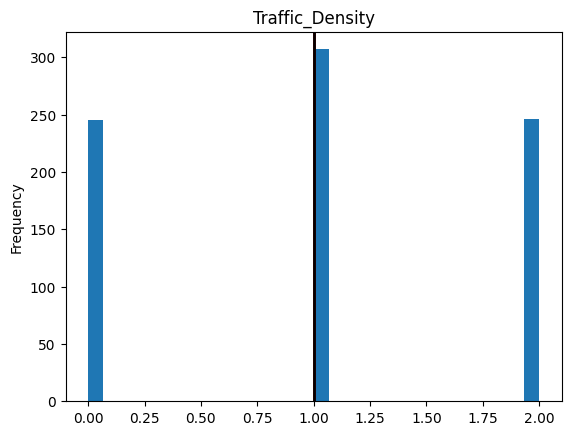

Speed_Limit - mean: 71.0501253132832, median: 60.0


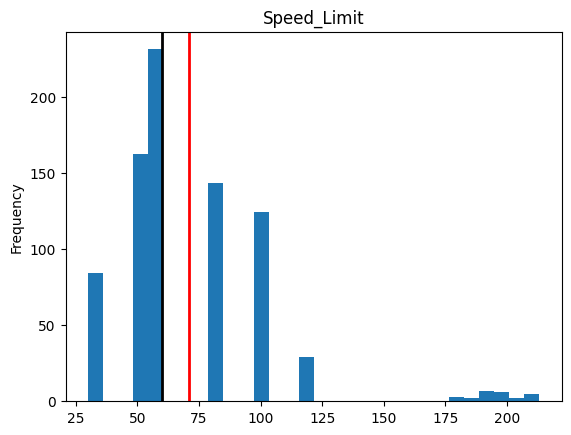

Number_of_Vehicles - mean: 3.2869674185463658, median: 3.0


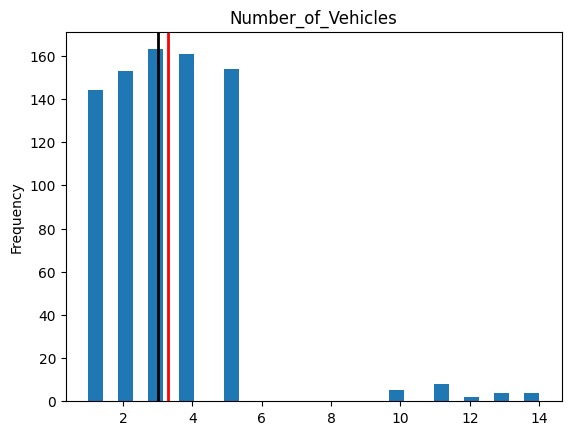

Driver_Alcohol - mean: 0.16040100250626566, median: 0.0


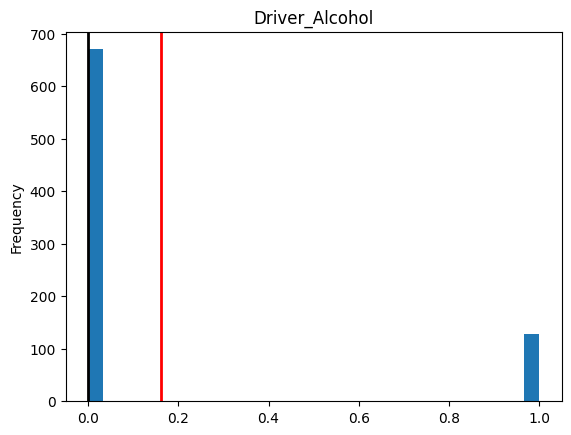

Driver_Age - mean: 43.2593984962406, median: 43.0


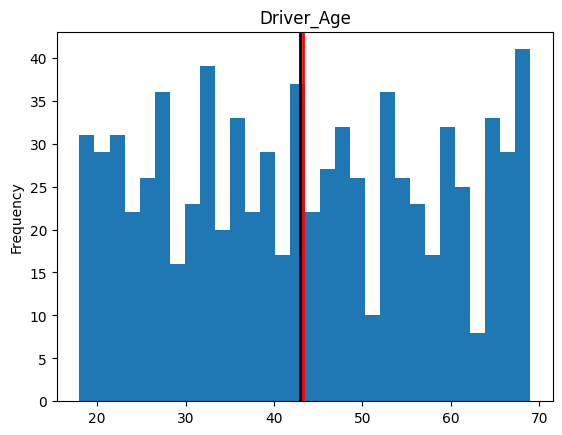

Driver_Experience - mean: 38.9812030075188, median: 39.0


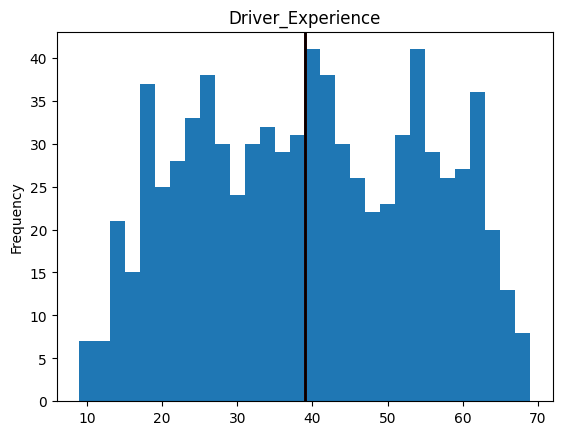

Accident - mean: 0.29949874686716793, median: 0.0


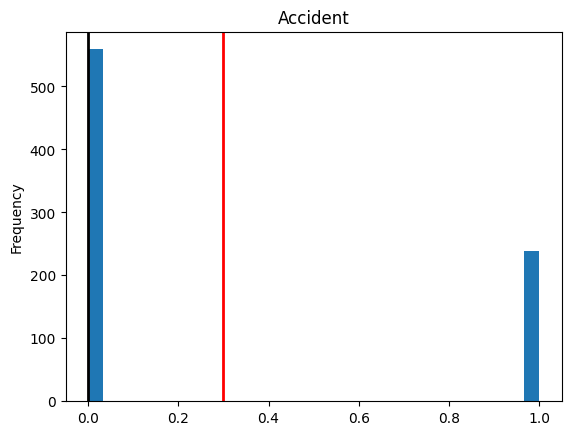

In [8]:
for i in num_col:
    print(f"{i} - mean: {accident_data[i].mean()}, median: {accident_data[i].median()}")
    accident_data[i].plot(kind='hist', bins=30, title=i)
    plt.axvline(accident_data[i].mean(), color='red', linestyle='solid', linewidth=2)
    plt.axvline(accident_data[i].median(), color='black', linestyle='solid', linewidth=2)
    plt.show()

In [9]:
accident_data['Traffic_Density'].fillna(accident_data['Traffic_Density'].median(), inplace=True)
accident_data['Speed_Limit'].fillna(accident_data['Speed_Limit'].median(), inplace=True)
accident_data['Number_of_Vehicles'].fillna(accident_data['Number_of_Vehicles'].median(), inplace=True)
accident_data['Driver_Alcohol'].fillna(accident_data['Driver_Alcohol'].median(), inplace=True)
accident_data['Driver_Age'].fillna(accident_data['Driver_Age'].median(), inplace=True)
accident_data['Driver_Experience'].fillna(accident_data['Driver_Experience'].median(), inplace=True)
accident_data['Accident'].fillna(accident_data['Accident'].median(), inplace=True)

In [10]:
car_acc_col = accident_data.select_dtypes(include='object').columns
for col in car_acc_col:
    print(f"Unique values in {col}: {accident_data[col].unique()}")

Unique values in Weather: ['Rainy' 'Clear' 'Foggy' 'Stormy' nan 'Snowy']
Unique values in Road_Type: ['City Road' 'Rural Road' 'Highway' nan 'Mountain Road']
Unique values in Time_of_Day: ['Morning' 'Night' 'Evening' 'Afternoon' nan]
Unique values in Accident_Severity: [nan 'Moderate' 'Low' 'High']
Unique values in Road_Condition: ['Wet' 'Icy' 'Under Construction' 'Dry' nan]
Unique values in Vehicle_Type: ['Car' 'Truck' 'Bus' 'Motorcycle' nan]
Unique values in Road_Light_Condition: ['Artificial Light' 'Daylight' 'No Light' nan]


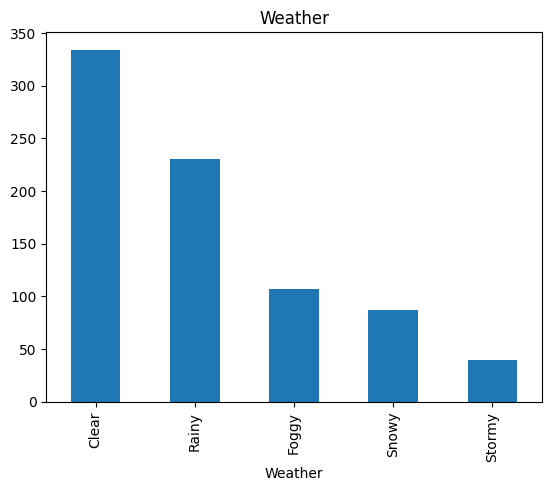

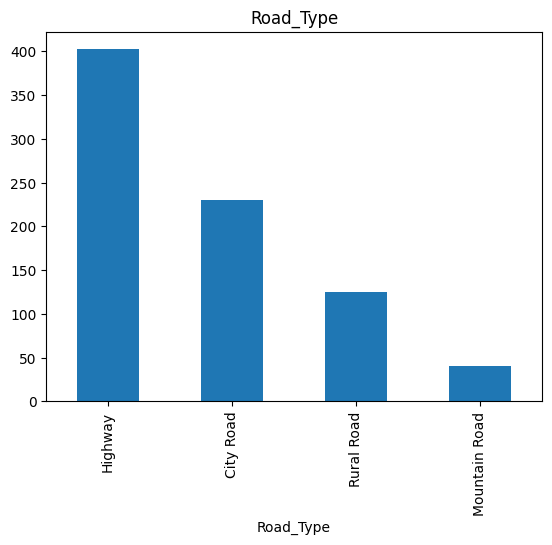

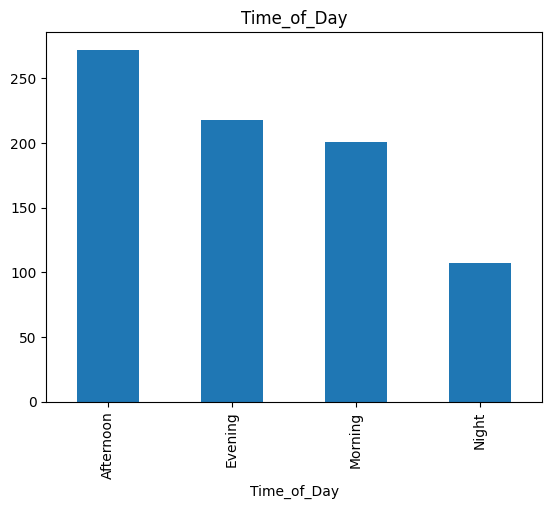

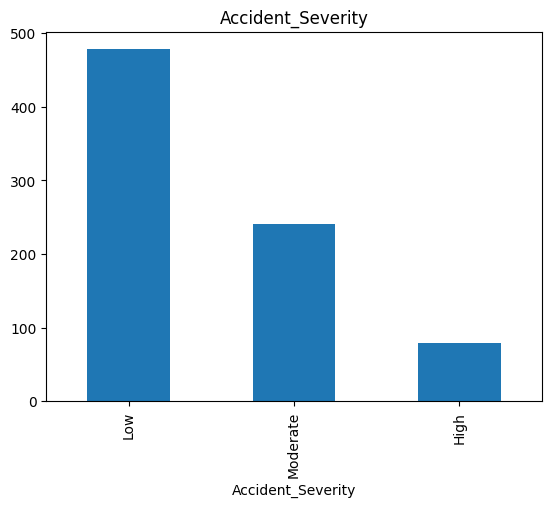

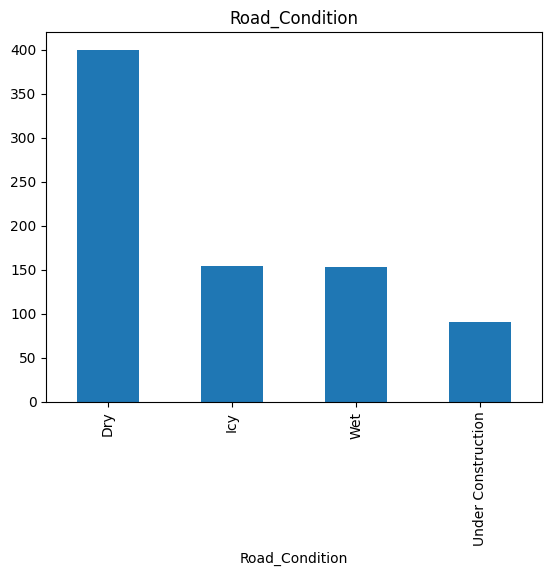

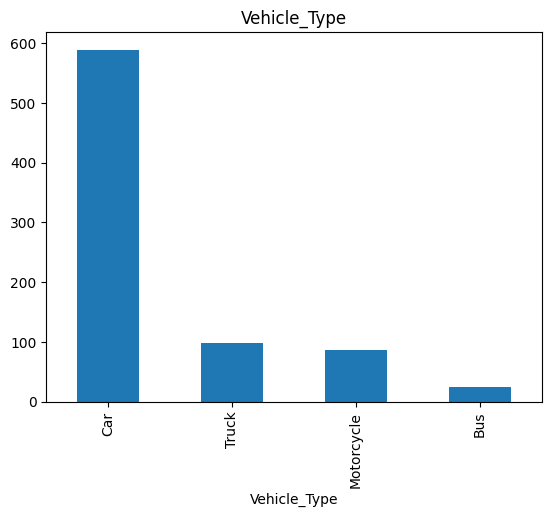

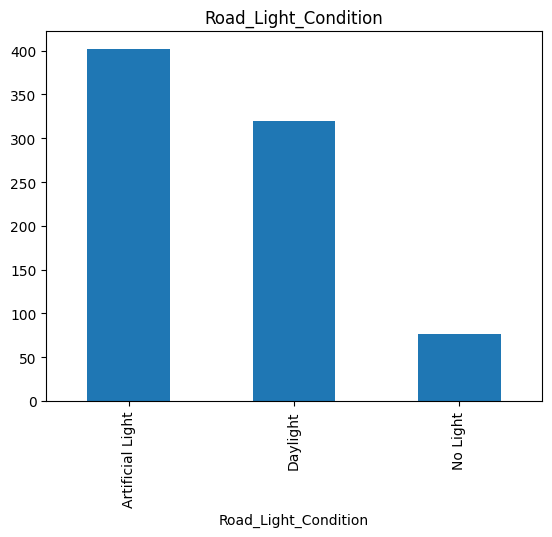

In [11]:
for i in car_acc_col :
    accident_data[i].value_counts().plot(kind="bar", stacked=True,title=i)
    plt.show()

In [12]:
accident_data['Weather'] = accident_data['Weather'].fillna(accident_data['Weather'].mode()[0])
accident_data['Road_Type'] = accident_data['Road_Type'].fillna(accident_data['Road_Type'].mode()[0])
accident_data['Time_of_Day'] = accident_data['Time_of_Day'].fillna(accident_data['Time_of_Day'].mode()[0])
accident_data['Accident_Severity'] = accident_data['Accident_Severity'].fillna(accident_data['Accident_Severity'].mode()[0])
accident_data['Road_Condition'] = accident_data['Road_Condition'].fillna(accident_data['Road_Condition'].mode()[0])
accident_data['Vehicle_Type'] = accident_data['Vehicle_Type'].fillna(accident_data['Vehicle_Type'].mode()[0])
accident_data['Road_Light_Condition'] = accident_data['Road_Light_Condition'].fillna(accident_data['Road_Light_Condition'].mode()[0])

In [13]:
accident_data['Accident'].value_counts()

Accident
0.0    601
1.0    239
Name: count, dtype: int64

In [14]:
# Drop rows with missing values (NaN) in the 'Accident' column
accident_data.dropna(subset=['Accident'], inplace=True)

In [15]:
# Tts clearly unbalanced, so upsample the minority
majority_data= accident_data[ accident_data['Accident'] == 0.0 ]
minority_data= accident_data[ accident_data['Accident'] == 1.0 ]

In [16]:
# Upsample minority data
upsampled_minority_data = resample(minority_data, replace=True, n_samples=len(majority_data), random_state=42)

# Reset the index of the upsampled minority data
upsampled_minority_data = upsampled_minority_data.reset_index(drop=True)

# Reset index for majority data too (if necessary)
majority_data = majority_data.reset_index(drop=True)

# Combine the datasets into balanced_data
balanced_data = pd.concat([majority_data, upsampled_minority_data]).reset_index(drop=True)

In [17]:
balanced_data.shape

(1202, 14)

In [18]:
balanced_data['Accident'].value_counts()

Accident
0.0    601
1.0    601
Name: count, dtype: int64

In [19]:
balanced_data.head()

,Weather,Road_Type,Time_of_Day,Traffic_Density,Speed_Limit,Number_of_Vehicles,Driver_Alcohol,Accident_Severity,Road_Condition,Vehicle_Type,Driver_Age,Driver_Experience,Road_Light_Condition,Accident
0,Rainy,City Road,Morning,1.0,100.0,5.0,0.0,Low,Wet,Car,51.0,48.0,Artificial Light,0.0
1,Clear,Rural Road,Night,1.0,120.0,3.0,0.0,Moderate,Wet,Truck,49.0,43.0,Artificial Light,0.0
2,Rainy,Highway,Evening,1.0,60.0,4.0,0.0,Low,Icy,Car,54.0,52.0,Artificial Light,0.0
3,Clear,City Road,Afternoon,2.0,60.0,3.0,0.0,Low,Under Construction,Bus,34.0,31.0,Daylight,0.0
4,Clear,Rural Road,Night,0.0,120.0,3.0,0.0,Moderate,Dry,Truck,49.0,43.0,Artificial Light,0.0


In [20]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Weather               1202 non-null   object 
 1   Road_Type             1202 non-null   object 
 2   Time_of_Day           1202 non-null   object 
 3   Traffic_Density       1202 non-null   float64
 4   Speed_Limit           1202 non-null   float64
 5   Number_of_Vehicles    1202 non-null   float64
 6   Driver_Alcohol        1202 non-null   float64
 7   Accident_Severity     1202 non-null   object 
 8   Road_Condition        1202 non-null   object 
 9   Vehicle_Type          1202 non-null   object 
 10  Driver_Age            1202 non-null   float64
 11  Driver_Experience     1202 non-null   float64
 12  Road_Light_Condition  1202 non-null   object 
 13  Accident              1202 non-null   float64
dtypes: float64(7), object(7)
memory usage: 131.6+ KB


In [21]:
balanced_data.isna().sum()

Weather                 0
Road_Type               0
Time_of_Day             0
Traffic_Density         0
Speed_Limit             0
Number_of_Vehicles      0
Driver_Alcohol          0
Accident_Severity       0
Road_Condition          0
Vehicle_Type            0
Driver_Age              0
Driver_Experience       0
Road_Light_Condition    0
Accident                0
dtype: int64

In [22]:
# Features and target
X = balanced_data.drop(['Accident'], axis = 1)
y = balanced_data['Accident']


In [27]:
# Define the categorical features
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(exclude='object').columns


# Define the ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical_features', 'passthrough', numerical_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


In [24]:
# Stratified train-test split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [26]:
# List of models to evaluate for the best performance
models = [
    LogisticRegression(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

# Initialize variables to track the best model and its F1 score
best_model = None
best_f1 = 0

# Iterate through each model in the list
for model in models:
    # Create a pipeline that includes preprocessing and the model
    pipe = Pipeline([
        ('preprocessor', preprocessor),  # Apply preprocessing steps
        ('model', model)                 # Train the current model
    ])

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Predict the labels for the test data
    y_preds = pipe.predict(X_test)

    # Calculate the F1 score for the current model
    f1_sc = f1_score(y_test, y_preds)

    # If the current model has a higher F1 score, update the best model
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model

    # Print the F1 score for the current model
    print(f"{model} := {f1_sc}\n")

# Print the best model and its F1 score
print(f"Best Model: {best_model.__class__.__name__} with F1 Score: {best_f1:.4f}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() := 0.5301204819277109

RandomForestClassifier() := 0.875

GradientBoostingClassifier() := 0.7380952380952381

Best Model: RandomForestClassifier with F1 Score: 0.8750
